# Imports

In [1]:
import os
import datetime
import dateutil.parser
import sys
sys.path.append("..")

import pandas as pd
import matplotlib.pyplot as plt

from src.utils import read_data
from src.preprocessing import deep_clean_tweet, clean_tweet_for_transformers
from src.analysis import get_most_common_words, get_wordcloud

# Import Dataset and extract features for visualizations

In [2]:
#Load Trainig Dataset
filename = '../data/webis_train.csv'
df = read_data(filename)

In [3]:
# convert timestamp column to datetime type and split into columns
df['timestamp'] = pd.to_datetime(df['postTimestamp'])
df['weekdaynum'] = df['timestamp'].dt.dayofweek
df['weekday'] = df['timestamp'].dt.weekday_name
df['monthdaynum'] = df['timestamp'].dt.day
df['hourofday'] = df['timestamp'].dt.hour

In [4]:
#Extract #hashtags and @mentions in tweets
df['hashtags'] = df.postText.str.findall(r'#[^\s#@]*')
df['mention'] = df.postText.str.findall(r'@[^\s@#]*')

## Labels Distribution

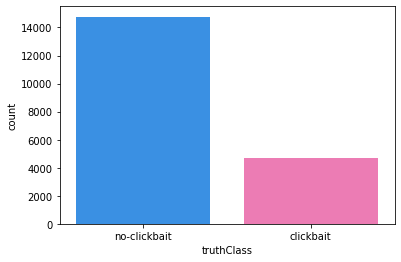

In [5]:
import seaborn as sns
sns.countplot(x='truthClass', data=df, palette=['dodgerblue',"hotpink"])

In [6]:
print('Percentage of clickbait tweets: ', len(df.loc[df.truthClass == 'clickbait'])/len(df))
print('Percentage of no-clickbait tweets: ', len(df.loc[df.truthClass != 'clickbait'])/len(df))

Percentage of clickbait tweets:  0.24204475467049888
Percentage of no-clickbait tweets:  0.7579552453295011


From this analysis of the target variable, we can deduce that this is an unbalanced classification problem. 
To resolve this issue, if impacting on the model results, 3 main strategies can be adopted: <br />
* class weights while training <br />
* undersampling the majority class (downside: lose information) <br />
* oversampling the minority class (with text it means substituting with synonyms or squeeze the input sequences)

In principle, if the problem can be attenuated with class_weights, it should be better since it avoids information loss and potential noise introduction in the training dataset. 

In [7]:
df_neg = df.loc[df.truthClass == 'no-clickbait']
df_pos = df.loc[df.truthClass == 'clickbait']

# Most frequent Hashtags

In [8]:
hashtags_all = [''.join(x) for x in df.hashtags if len(x) >0]
hashtags_clickbait = [''.join(x) for x in df_pos.hashtags if len(x) >0]
hashtags_no_clickbait = [''.join(x) for x in df_neg.hashtags if len(x) >0]

Text(0, 0.5, 'Hashtags')

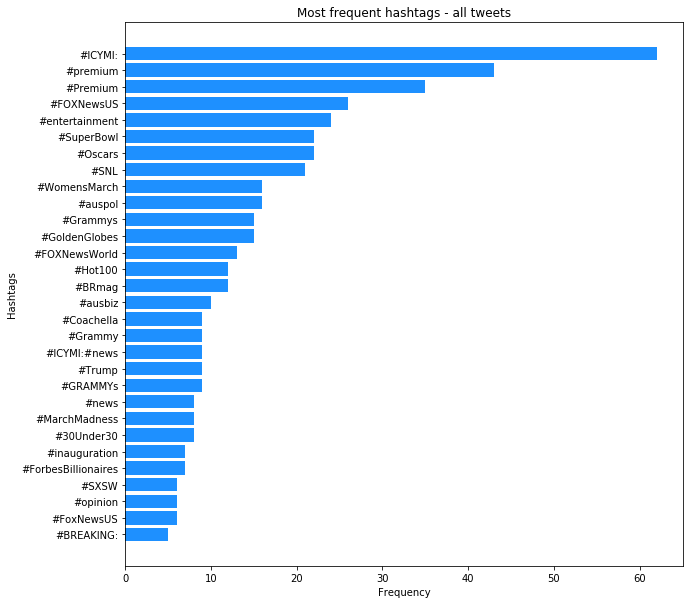

In [9]:
get_most_common_words(hashtags_all, max_words= 30)
plt.title('Most frequent hashtags - all tweets')
plt.xlabel('Frequency')
plt.ylabel('Hashtags')

Text(0, 0.5, 'Hashtags')

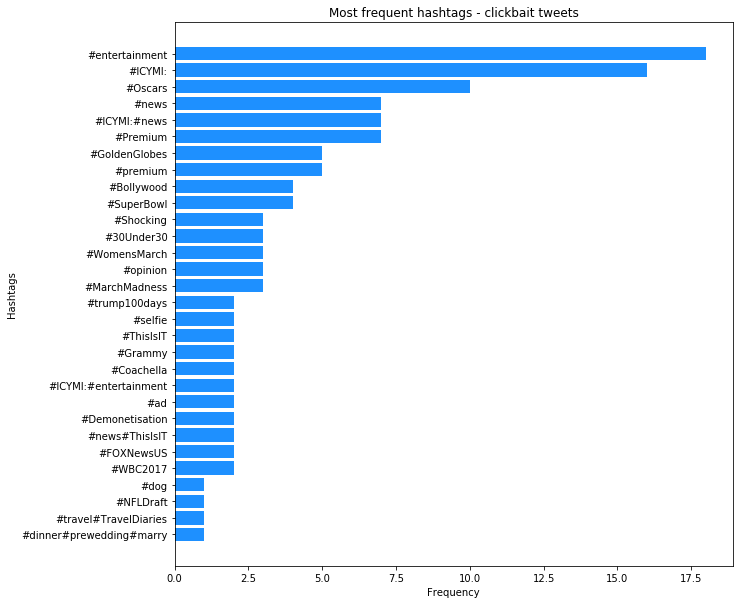

In [10]:
get_most_common_words(hashtags_clickbait, max_words= 30)
plt.title('Most frequent hashtags - clickbait tweets')
plt.xlabel('Frequency')
plt.ylabel('Hashtags')

Text(0, 0.5, 'Hashtags')

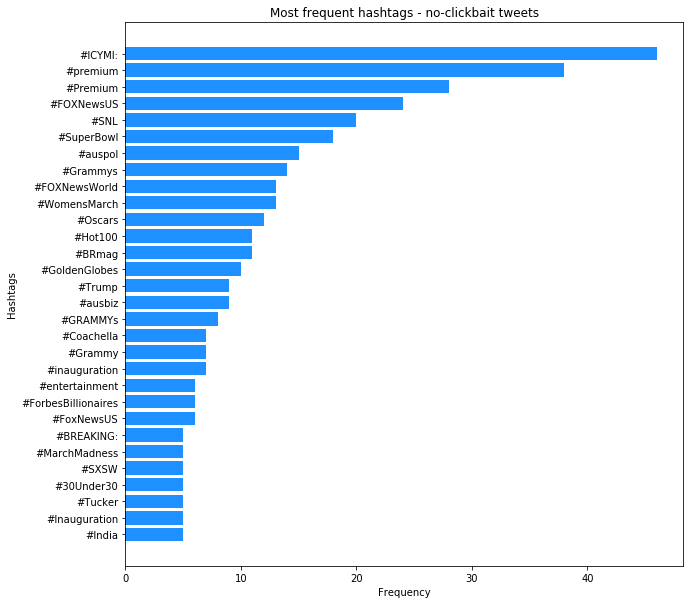

In [11]:
get_most_common_words(hashtags_no_clickbait, max_words= 30)
plt.title('Most frequent hashtags - no-clickbait tweets')
plt.xlabel('Frequency')
plt.ylabel('Hashtags')

Among the most frequent hasthtags we see that a lot of them refer to news channels or the entertainment sector. For instance, we have hashtags for Oscars and Golden Globes celebration, as well as some referring to sport events like the SuperBowl or music context such as the Grammy Awards.
Trump also appear as a frequent hashtags, especially among no-clickbait tweets.

# Most frequent Mentions

In [12]:
mentions_all = [''.join(x) for x in df.mention if len(x) >0]
mentions_clickbait = [''.join(x) for x in df_pos.mention if len(x) >0]
mentions_no_clickbait = [''.join(x) for x in df_neg.mention if len(x) >0]

Text(0, 0.5, 'Mentions')

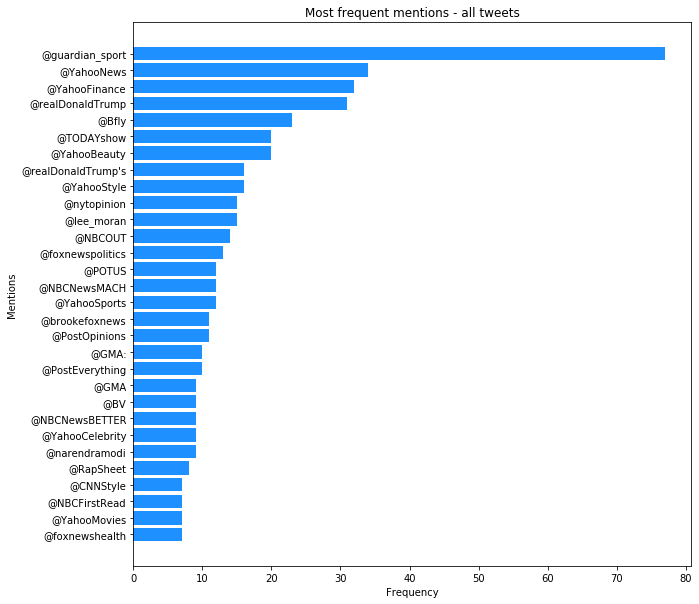

In [13]:
get_most_common_words(mentions_all, max_words= 30)
plt.title('Most frequent mentions - all tweets')
plt.xlabel('Frequency')
plt.ylabel('Mentions')

Text(0, 0.5, 'Mentions')

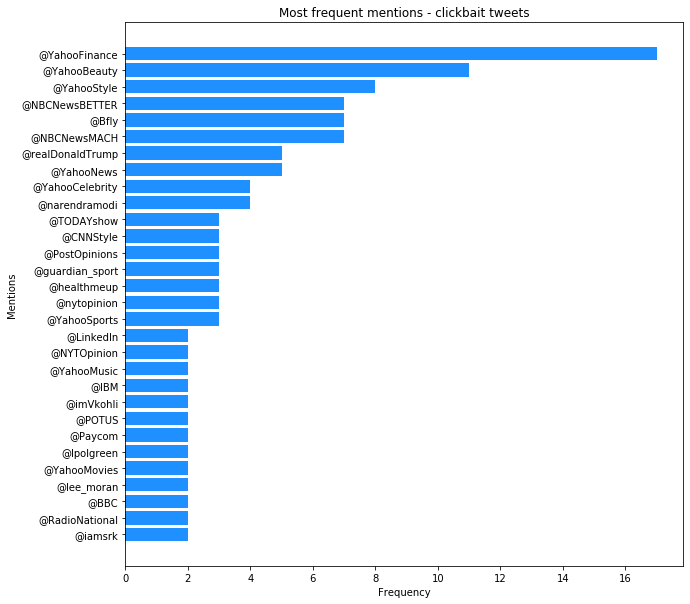

In [14]:
get_most_common_words(mentions_clickbait, max_words= 30)
plt.title('Most frequent mentions - clickbait tweets')
plt.xlabel('Frequency')
plt.ylabel('Mentions')

Text(0, 0.5, 'Mentions')

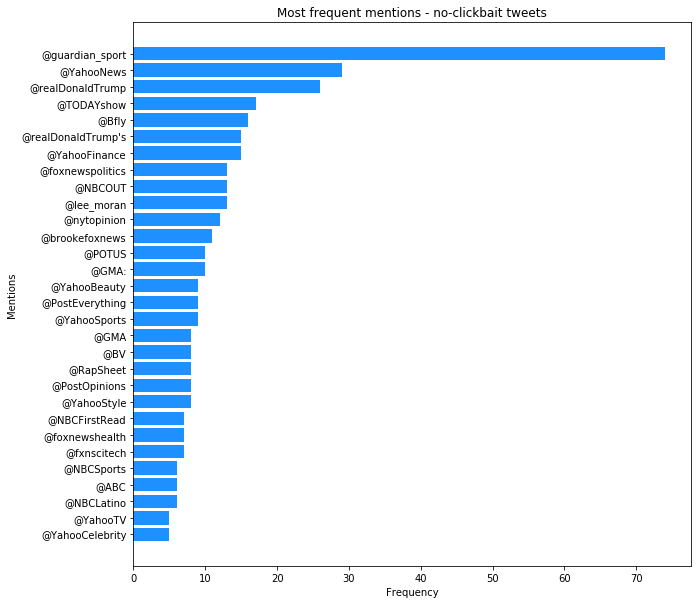

In [15]:
get_most_common_words(mentions_no_clickbait, max_words= 30)
plt.title('Most frequent mentions - no-clickbait tweets')
plt.xlabel('Frequency')
plt.ylabel('Mentions')

From the most common mentions, it can be clearly appreciated that in the tweets text there are a lot of mentions to Yahoo sites; this is especially true for clickbait tweets that have 8/30 most common mentions referring to Yahoo websites.

# Preprocessing Tweets Text

In order to clean tweets for visualizations we apply a larger preprocessing function (including stopwords and contractions removal) so that the resulting text will be more homogeneous and thus more suitable for visualizations such as most common words plots.

In [16]:
#Apply tweet cleaning function
df['cleanedText'] = df.postText.apply(lambda x: deep_clean_tweet(x.lower()))

In [17]:
df_neg = df.loc[df.truthClass == 'no-clickbait']
df_pos = df.loc[df.truthClass == 'clickbait']

# WordClouds

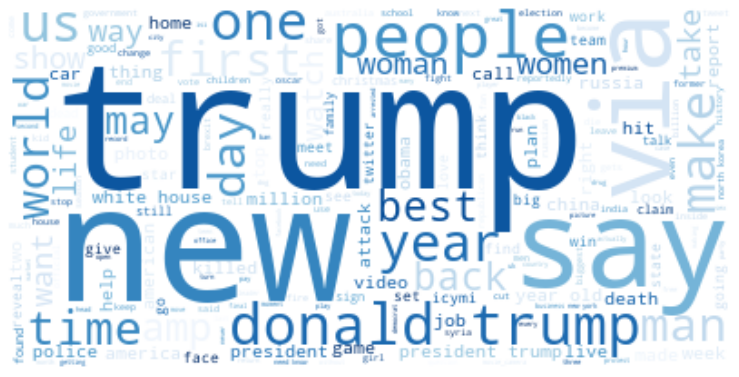

In [18]:
get_wordcloud(df.cleanedText.str.replace('@USER', '')) ##avoid @USER in the visualizations

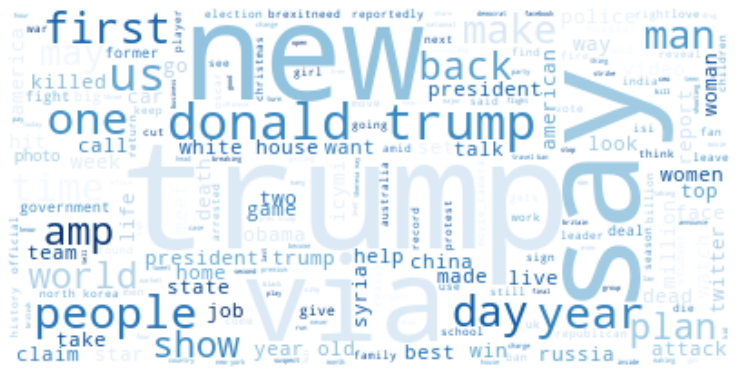

In [19]:
get_wordcloud(df_neg.cleanedText.str.replace('@USER', ''))

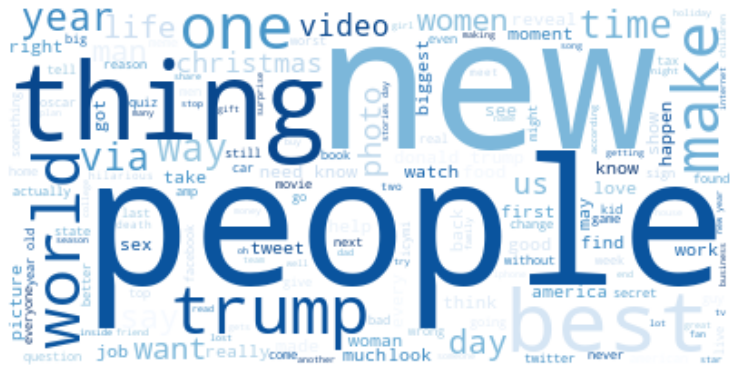

In [20]:
get_wordcloud(df_pos.cleanedText.str.replace('@USER', ''))

Fromt the wordclouds 'Trump' token is really visible in the 3 wordclouds, but more in no-clickbait tweets. The other common words are much less relevant in terms of appearances and no clear pattern can be discerned among all tokens.

# Most Frequent Words

Text(0, 0.5, 'Words')

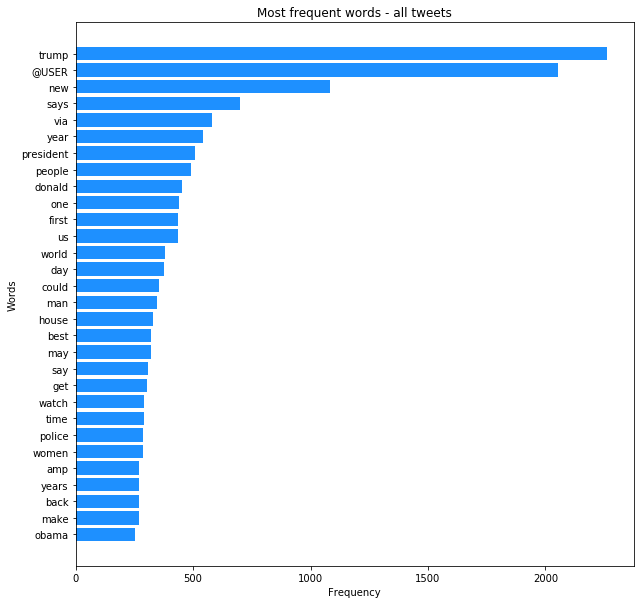

In [21]:
get_most_common_words(" ".join(df["cleanedText"]).split(), max_words= 30)
plt.title('Most frequent words - all tweets')
plt.xlabel('Frequency')
plt.ylabel('Words')

Text(0, 0.5, 'Words')

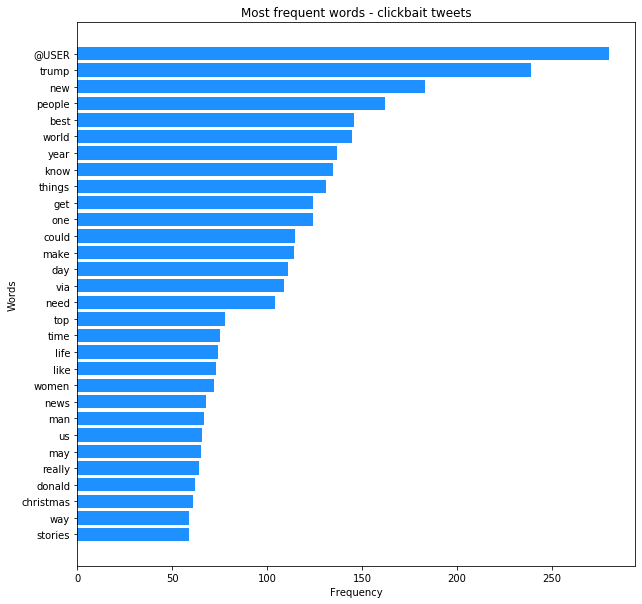

In [22]:
get_most_common_words(" ".join(df_pos["cleanedText"]).split(), max_words= 30)
plt.title('Most frequent words - clickbait tweets')
plt.xlabel('Frequency')
plt.ylabel('Words')

Text(0, 0.5, 'Words')

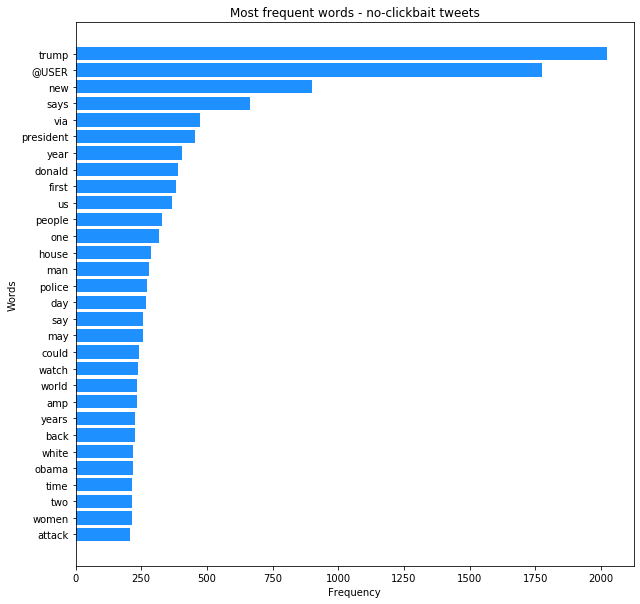

In [23]:
get_most_common_words(" ".join(df_neg["cleanedText"]).split(), max_words= 30)
plt.title('Most frequent words - no-clickbait tweets')
plt.xlabel('Frequency')
plt.ylabel('Words')

From the distributions of the most common words after preprocessing not much can be deduced, apart from 'trump' being the most frequent word across all tweets.

# Analize tweets post time

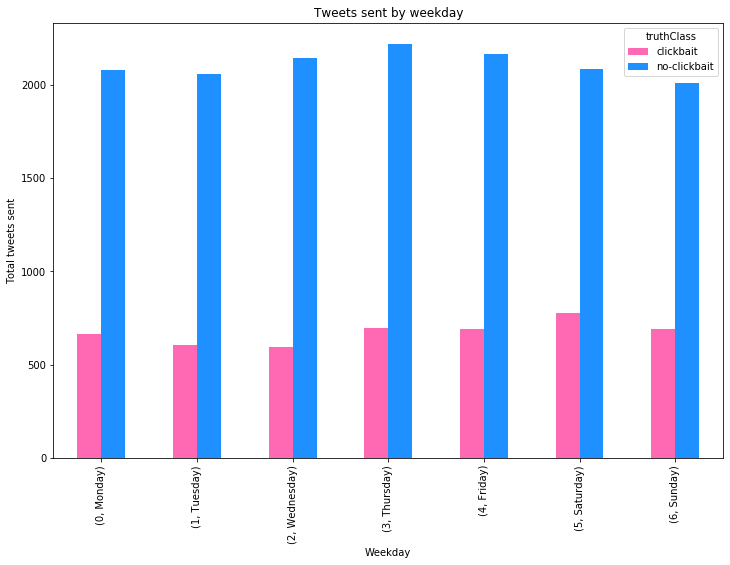

In [24]:
#Extract plot for clickbait and no-clickbait tweets published by weekday
colors = {'clickbait':'#1E90FF', 'no-clickbait':'#FF69B4'}
df.pivot_table(index=['weekdaynum','weekday'],values='id',aggfunc='count', columns='truthClass').plot(kind='bar',figsize=(12,8),color= df['truthClass'].map(colors))
plt.ylabel('Total tweets sent')
plt.xlabel('Weekday')
plt.title('Tweets sent by weekday');

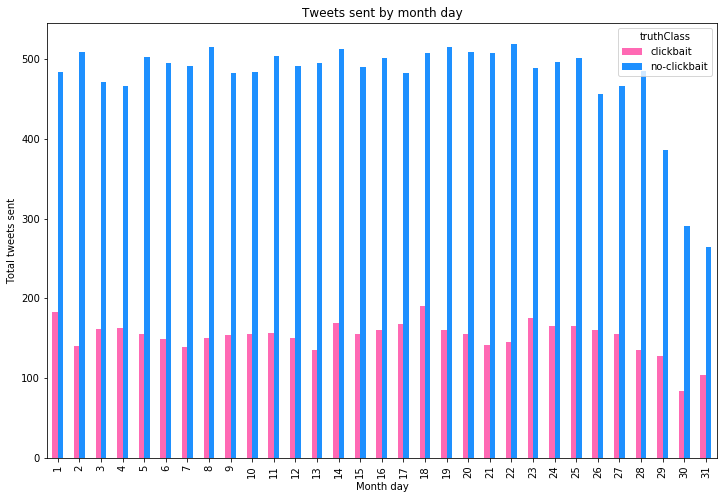

In [25]:
#Extract plot for clickbait and no-clickbait tweets published by day of the month
df.pivot_table(index='monthdaynum',values='id',aggfunc='count', columns='truthClass').plot(kind='bar',figsize=(12,8),color= df['truthClass'].map(colors))
plt.ylabel('Total tweets sent')
plt.xlabel('Month day')
plt.title('Tweets sent by month day');

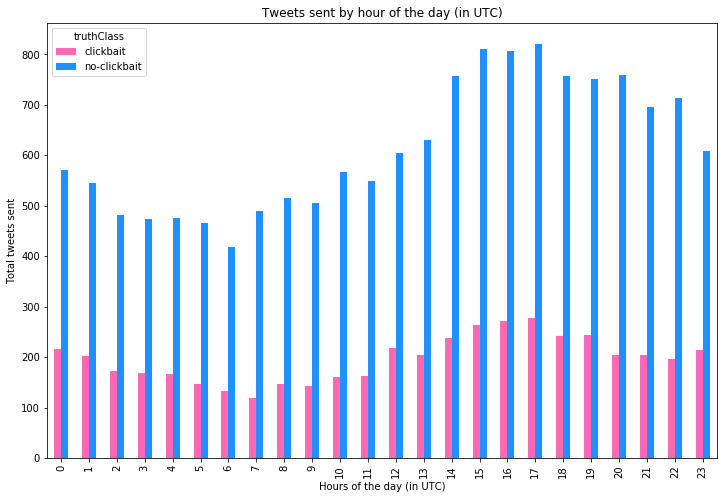

In [26]:
#Extract plot for clickbait and no-clickbait tweets published by hour
df.pivot_table(index='hourofday',values='id',aggfunc='count', columns='truthClass').plot(kind='bar',figsize=(12,8),color= df['truthClass'].map(colors))
plt.ylabel('Total tweets sent')
plt.xlabel('Hours of the day (in UTC)')
plt.title('Tweets sent by hour of the day (in UTC)');


From the previous plots we can appreciate that data has been gathered equally through the different time frames, having equal distributions between classes.